<a id="top"></a>
# WFC3/IR IMA Visualization Tools with An Example of Time Variable Background


## Learning Goals

The main purpose of this notebook is to familiarize users with the structure of the WFC3/IR IMA files, to visualize individual reads and the difference between reads, and to plot the cumulative signal and count rate throughout the MULTIACCUM exposure. These visualization tools may be used to identify issues with the data, for example, a [guidestar (GS) failure](https://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=ID7002010), a [satellite trail](https://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=IB5X02030) in a specific read, or time variable background, which may take the form of scattered light or He I 10830 Å airglow line emission. 

This notebook walks through: 

- Exploring WFC3/IR IMA Data Structure;
- How to find and select individual reads in an IMA file;
- How to show individual reads as images;
- Plotting the signal ramp through subsequent reads;
- Plotting the difference in signal between reads using two different methods.



## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Downloading Data](#main) <br>
- [2.1 Download Example MULTIACCUM Observation](#load) <br>
- [2.2 WFC3/IR File Information](#file) <br>


[3. Visualizing Individual Reads of IMA Images](#vis) <br>
[4. Taking the Difference Between Reads: The Cumulative Rate](#cumulative) <br>
[5. A More Accurate Difference Between Reads: The Instantaneous Rate](#instantaneous) <br>


[6. Conclusions](#conclusions)<br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction <a id="intro"></a>


**Observing with the WFC3/IR MULTIACCUM Mode**


As discussed in section [7.7 of the WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-7-ir-exposure-and-readout), the only observing mode available for the WFC3/IR channel is the MULTIACCUM mode, which samples the signal multiple times as an exposure accumulates. Exposures are taken in "a sequence of non-destructive reads specified by the user from a variety of pre-defined configurations with both constant (SPARS) and increasing (STEP) time intervals between subsequent reads. At the time of each read,
the accumulated charge on each pixel is recorded and this charge accumulation history for
a given exposure — the 'ramp' — is recorded in the RAW data files." The maximum number of reads (following the zero read) during an exposure is 15, which are collected as the signal ramps up.


Multiple readouts in the MULTIACCUM mode are advantageous for three key reasons. First, they increase the dynamic range of the image. The signal in a pixel that is saturated by the end of the exposure is recorded multiple times, including before saturation. Second, cosmic-ray events that occur throughout the exposure can be anaylzed and identified in individual reads and subsequently removed. Finally, by fitting to multiple reads, one can reduce the effective read noise in an observation. 

See section [7.7 of the WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-7-ir-exposure-and-readout) for more details.


**Time-Variable Background in the WFC3/IR Channel**

In WFC3/IR images, the sky background may be comprised of one or more of the following components: zodiacal light, [scattered light from the bright Earth limb](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background), and [He I 10830 Å airglow line emission](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background) from helium atoms excited by sunlight in the Earth's upper atmosphere. The zodiacal light, which depends on the orientation of the target with respect to the sun, varies throughout the year but is effectively constant within a given exposure/orbit/visit. However, the scattered light and line emission components can vary within an orbit and even within a single exposure, leading to a background that varies with time. In this notebook, we will show an example of time-variable background due to Earth limb scattered light (made when HST is pointing near the bright Earth limb), which results in a spatially variable signal with the leftmost (x<400) columns of the detector being subject to background levels up to twice as bright as that on the rest of the chip.

In the following sections, we show how to identify the impacted reads. In future [WFC3 Library](https://github.com/spacetelescope/WFC3Library) notebooks, Correcting for Scattered Light in WFC3/IR Exposures: Using `calwf3` to Exclude Bad Reads (O'Connor, in prep.) and Correcting for Scattered Light in IR Exposures: Manually Excluding Bad Reads (O'Connor, in prep.), we show how to reprocess the exposure while excluding those reads. Here, we show how to compute and plot the median background rate (e.g. the difference between IMA reads) and we compare the background in different regions of the detector.  

See section [7.10 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background) for more details.

## 1. Imports <a id="import"></a>
    
We use the following libraries: 
 
- *os* for splitting file paths 
- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy.io fits* for accessing FITS files
- *astroquery* for downlaoding data from MAST

We import the following module:
- *ima_visualization_and_differencing* to take the difference between reads, plot the ramp, and to visualize the difference in images


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astroquery.mast import Observations
import ima_visualization_and_differencing as diff

%matplotlib inline

## 2. Downloading Data <a id="main"></a>


### 2.1 Download Example MULTIACCUM Observation <a id="load"></a>

Here, we download two consecutive exposures from image association 'ICQTBB020' acquired in visit BB of program [14037](https://www.stsci.edu/hst/observing/program-information). This visit consists of two orbits of two exposures each, and we focus on the second orbit which contains two identical images of the target (filter=F140W, SAMP-SEQ=SPARS100, NSAMP=16). The first exposure 'icqtbbbxq' was acquired in the first half of the orbit and is strongly contaminated by scattered light. The second exposure 'icqtbbc0q' was acquired during the second half of the orbit and allows us to compare what one would see in a nominal image. 

When running this notebook, these dataset names may be replaced with your own observations. If running this notebook with just one observation, note that simple changes to each cell will allow you to run the notebook with just one image (these changes are suggested within each cell). We recommend that you step through this notebook first using the example observations given below. 

Let's query for the IR images using MAST, selecting both the IMA and FLT data products from the two exposures: 'icqtbbbxq' and 'icqtbbc0q'. 

In [2]:
EX_OBS = Observations.query_criteria(obs_id='ICQTBB020')
EXOBS_Prods = Observations.get_product_list(EX_OBS)
yourProd = Observations.filter_products(EXOBS_Prods, obs_id=[
                                        'icqtbbbxq', 'icqtbbc0q'], extension=["_ima.fits", "_flt.fits"])

In [3]:
yourProd

<Table masked=True length=4>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str3            str5       ...    str6       int64      str9 
-------- -------------- ---------------- ... ---------- ----------- -------
25006494            HST            image ...     PUBLIC           2   F140W
25006494            HST            image ...     PUBLIC           2   F140W
25006495            HST            image ...     PUBLIC           2   F140W
25006495            HST            image ...     PUBLIC           2   F140W

In [4]:
Observations.download_products(yourProd, mrp_only=False, cache=False)

 [Done]


 [Done]


 [Done]


 [Done]


<Table length=4>
                   Local Path                    Status  Message  URL  
                     str47                        str8    object object
----------------------------------------------- -------- ------- ------
./mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits COMPLETE    None   None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits COMPLETE    None   None
./mastDownload/HST/icqtbbc0q/icqtbbc0q_ima.fits COMPLETE    None   None
./mastDownload/HST/icqtbbc0q/icqtbbc0q_flt.fits COMPLETE    None   None

### 2.2 WFC3/IR File Information <a id="file"></a>


The figure below shows the WFC3/IR file structure corresponding to [Figure 2.4 of the Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-2-wfc3-data-structure/2-2-wfc3-file-structure). Note that for WFC3/IR data, each read or image set (IMSET) consists of five data arrays: SCI, ERR, DQ, SAMP, TIME. Consecutive MULTIACCUM readouts are stored in reverse chronological order, with [SCI,1] corresponding to the final, cumulative exposure. 

<img src="ir_data_format.png" alt="Diagram of WFC3/IR Data Format, consisting of four columns representing each IMA read, made up of a science array, an error array, DQ array, and integration time." style="width: 700px;"/>

The table below lists the IMSET, SAMPNUM, and SAMPTIME for a WFC3/IR SPARS100 exposure, modified from [Section 7.7 of the Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-7-ir-exposure-and-readout). Note that the image header keyword NSAMP reports a value of 16, but there are actually 15 science reads in the IMA file, following the 0th read (which has an exposure time of 0). While NSAMP keyword is reported in the primary header (extension 0), the SAMPNUM and SAMPTIME keywords may be found in the science header of each read, and these report the read (IMSET) number and the cumulative exposure time of each respective read. 

This table is similar to [Table 7.7](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-7-ir-exposure-and-readout#id-7.7IRExposureandReadout-table7.8), except that the column labelled NSAMP in the handbook is really the SAMPNUM. Note that we have added a row at the top of the table to highlight that IMSET [SCI,16] corresponds to the 0th read.

<img src="SAMPNUM_Table.png" alt="Table detailing the relationship between 'IMSET', SAMPNUM, and integration time for successive reads in an WFC3/IR image taken at a SPARS100 sample sequence." style="width: 300px;"/>

## 3. Visualizing Individual Reads of IMA Images<a id="vis"></a>


Next, let's check out the file structure of our WFC3/IR IMA FITS files. We define the paths to our images here.

In [5]:
ima_scattered = 'mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits'
flt_scattered = 'mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits'
ima_nominal = 'mastDownload/HST/icqtbbc0q/icqtbbc0q_ima.fits'
flt_nominal = 'mastDownload/HST/icqtbbc0q/icqtbbc0q_flt.fits'

image = fits.open(ima_scattered)
image.info()

Filename: mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     267   ()      
  1  SCI           1 ImageHDU        81   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        43   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        35   (1024, 1024)   int16   
  4  SAMP          1 ImageHDU        30   ()      
  5  TIME          1 ImageHDU        30   ()      
  6  SCI           2 ImageHDU        81   (1024, 1024)   float32   
  7  ERR           2 ImageHDU        43   (1024, 1024)   float32   
  8  DQ            2 ImageHDU        35   (1024, 1024)   int16   
  9  SAMP          2 ImageHDU        30   ()      
 10  TIME          2 ImageHDU        30   ()      
 11  SCI           3 ImageHDU        81   (1024, 1024)   float32   
 12  ERR           3 ImageHDU        43   (1024, 1024)   float32   
 13  DQ            3 ImageHDU        35   (1024, 1024)   int16   
 14  SAMP          3 

As we can see, the IMA contains 16 science (SCI) extensions or IMSETS, recorded in *reverse chronological* order in the file. For this observation, the "0th" read corresponds to the extension 76 or the 16th science extenstion, e.g. [SCI,16]. In the cells below, we show how to query the NSAMP and SAMPNUM keywords in the image headers.

In [6]:
prihdr = image[0].header
NSAMP = prihdr['NSAMP']
print(f'The total number of reads (including the 0th) is {NSAMP}.')

The total number of reads (including the 0th) is 16.


In [7]:
sci16hdr = image['SCI', 16].header
SAMPNUM_sci16 = sci16hdr['SAMPNUM']
SAMPTIME_sci16 = sci16hdr['SAMPTIME']
print(
    f'For sample number {SAMPNUM_sci16}, the exposure time is {SAMPTIME_sci16}s.')

For sample number 0, the exposure time is 0.0s.


In [8]:
sci1hdr = image['SCI', 1].header
SAMPNUM_sci1 = sci1hdr['SAMPNUM']
SAMPTIME_sci1 = sci1hdr['SAMPTIME']
print(
    f'For sample number {SAMPNUM_sci1}, the exposure time is {SAMPTIME_sci1:.3f}s.')

image.close()

For sample number 15, the exposure time is 1402.937s.


The 0th read [SCI,16] is taken at 0 seconds, while the 1st read [SCI,15] is taken just a few seconds after exposure start. Since it takes a finite time (2.93 sec) to read the full array, this short read represents the time delay between reading the first and last pixel. The rest of the reads are then taken at the time interval specified by the STEP or SPARS sequence. Here, we have chosen a dataset with SPARS100, which has a time interval of 100 seconds between reads. 

Let's compare the final read of the IMA and the corresponding FLT product for each dataset.

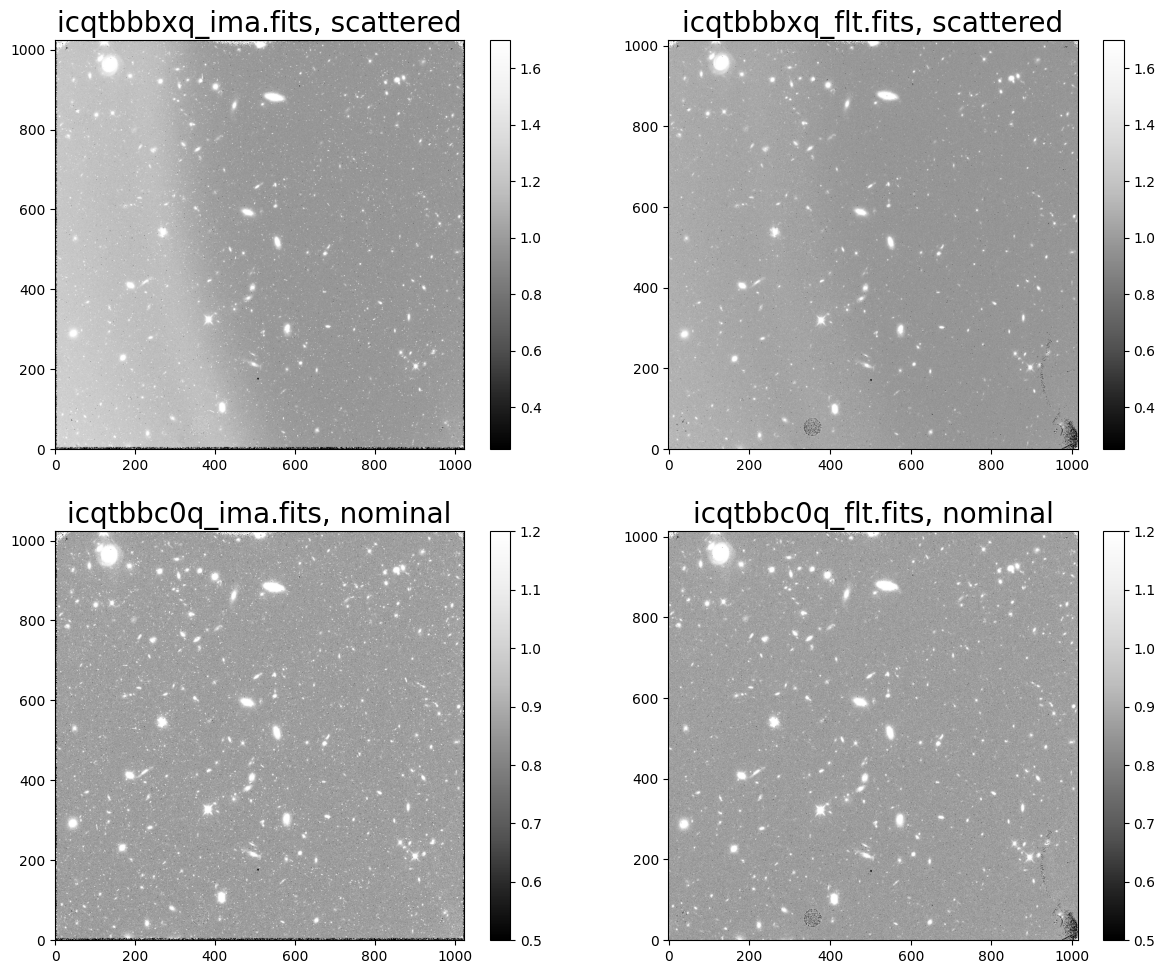

In [9]:
fig = plt.figure(figsize=(30, 30))
rows = 2
columns = 2
files = [ima_scattered, flt_scattered, ima_nominal, flt_nominal]

# If only analyzing one image, please remove the second ima,flt pair from the list
subplot_titles = ['scattered', 'nominal']

for i, file in enumerate(files):
    path, filename = os.path.split(file)

    with fits.open(file) as image:
        ax = fig.add_subplot(rows, columns, i + 1)
        title = f'{filename}, {subplot_titles[i//2]}'
        ax.set_title(title, fontsize=20)

        # Please change the vmin and vmax values to fit your own data
        vmin, vmax = (0.25, 1.7) if i < 2 else (0.5, 1.2)
        im = ax.imshow(
            image['SCI', 1].data, origin='lower', cmap='Greys_r', vmin=vmin, vmax=vmax
        )
        plt.colorbar(im, ax=ax)

plt.subplots_adjust(bottom=0.2, right=0.5, top=0.5)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Here, we see our target field. In the top row, we can see the scattered light in dataset 'icqtbbbxq' affecting the left side of both the IMA and FLT product. In the bottom row, we see the nominal IMA and FLT images for dataset 'icqtbbc0q'.

Note that FLT images differ from IMA images in that they have had cosmic rays removed by the [`calwf3` pipeline](https://hst-docs.stsci.edu/wfc3dhb/chapter-3-wfc3-data-calibration/3-3-ir-data-calibration-steps#id-3.3IRDataCalibrationSteps-3.3.10) via the CRCORR step which performs 'up-the-ramp' fitting.

To visually inspect each read of the IMA image, we can use the following snippet of code to create a multi-panel display. Each panel is shown with the same scale in electrons/second (e-/s) to highlight the increasing signal-to-noise in each successive read of the MULTIACCUM exposure. Here, we use the *read_wfc* funtion found in *ima_visualization_and_differencing.py* to grab the IMA science data from all reads as a data cube and the integration time as an array.

For a second tutorial on visualizing reads of the MULTIACCUM exposure, see the ["IMA Viewer"](https://github.com/spacetelescope/WFC3Library) notebook (Marinelli, in prep.) on the WFC3 Library GitHub. This notebook allows the user to create gifs looping through reads as the signal accumulates, which can be useful for quickly diagnosing any issues with the data.

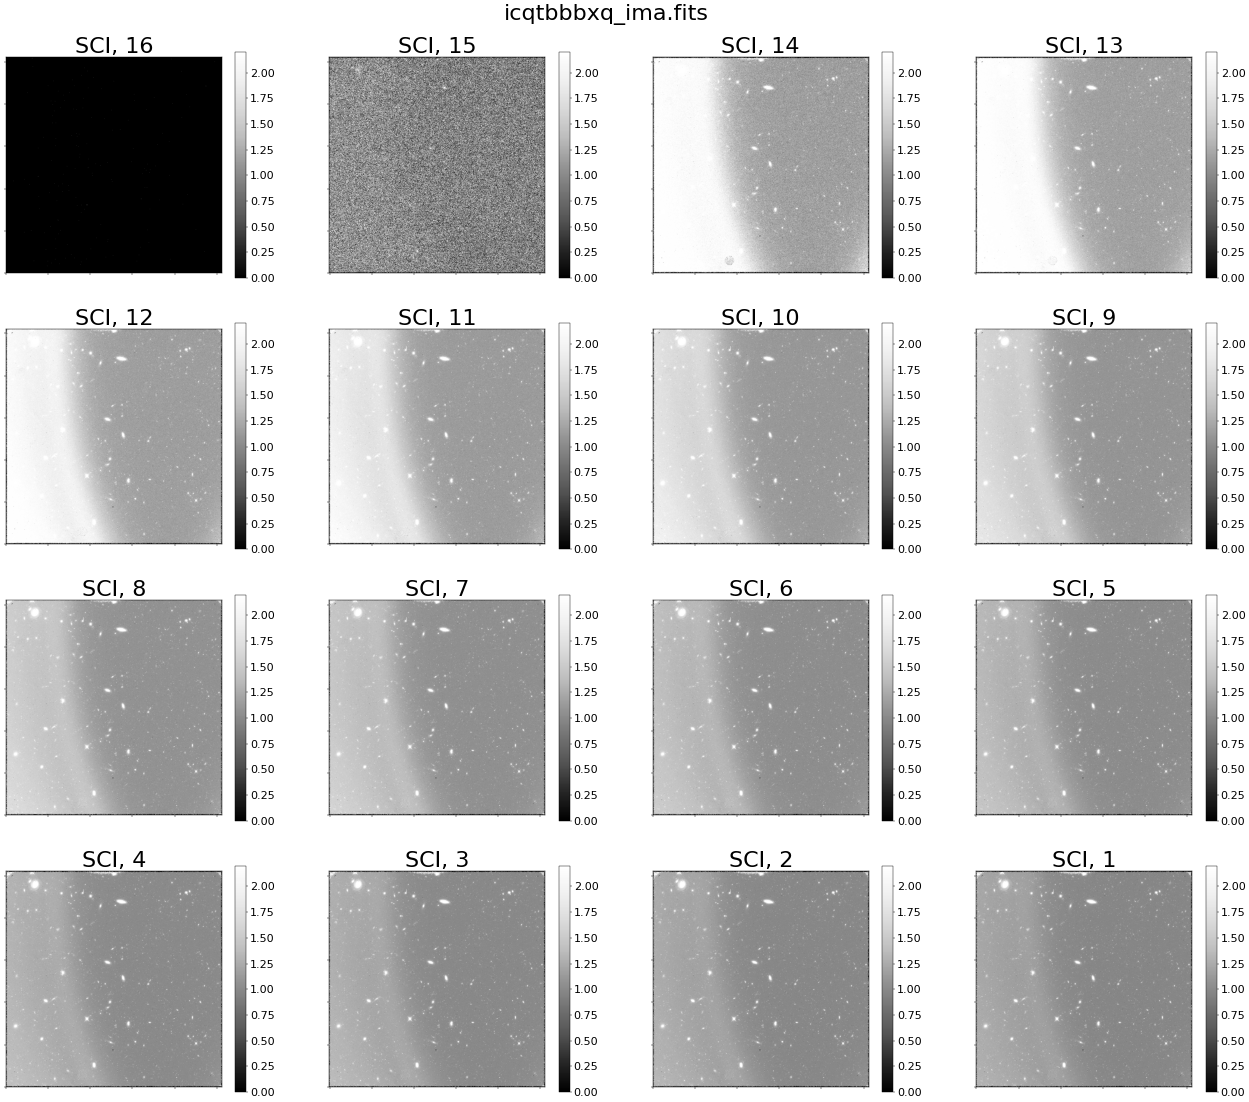

In [10]:
try:
    diff.plot_ima_subplots(ima_filename=ima_scattered, vmin=0, vmax=2.2)

except FileNotFoundError:
    print("No file by this name found")

Above, we see scattered light in every read in the cumulative exposure. In reality (as we will see later in this notebook), the scattered light is present only during the first few reads of the exposure. Because we are plotting reads with an accumulating signal, we see the scattered light affecting all reads of the IMA, even when the scattered light is no longer present. We will see this more clearly when visualizing the difference between reads.

Conversely, when we show individual reads from the nominal IMA file, we see no scattered light (as seen below).

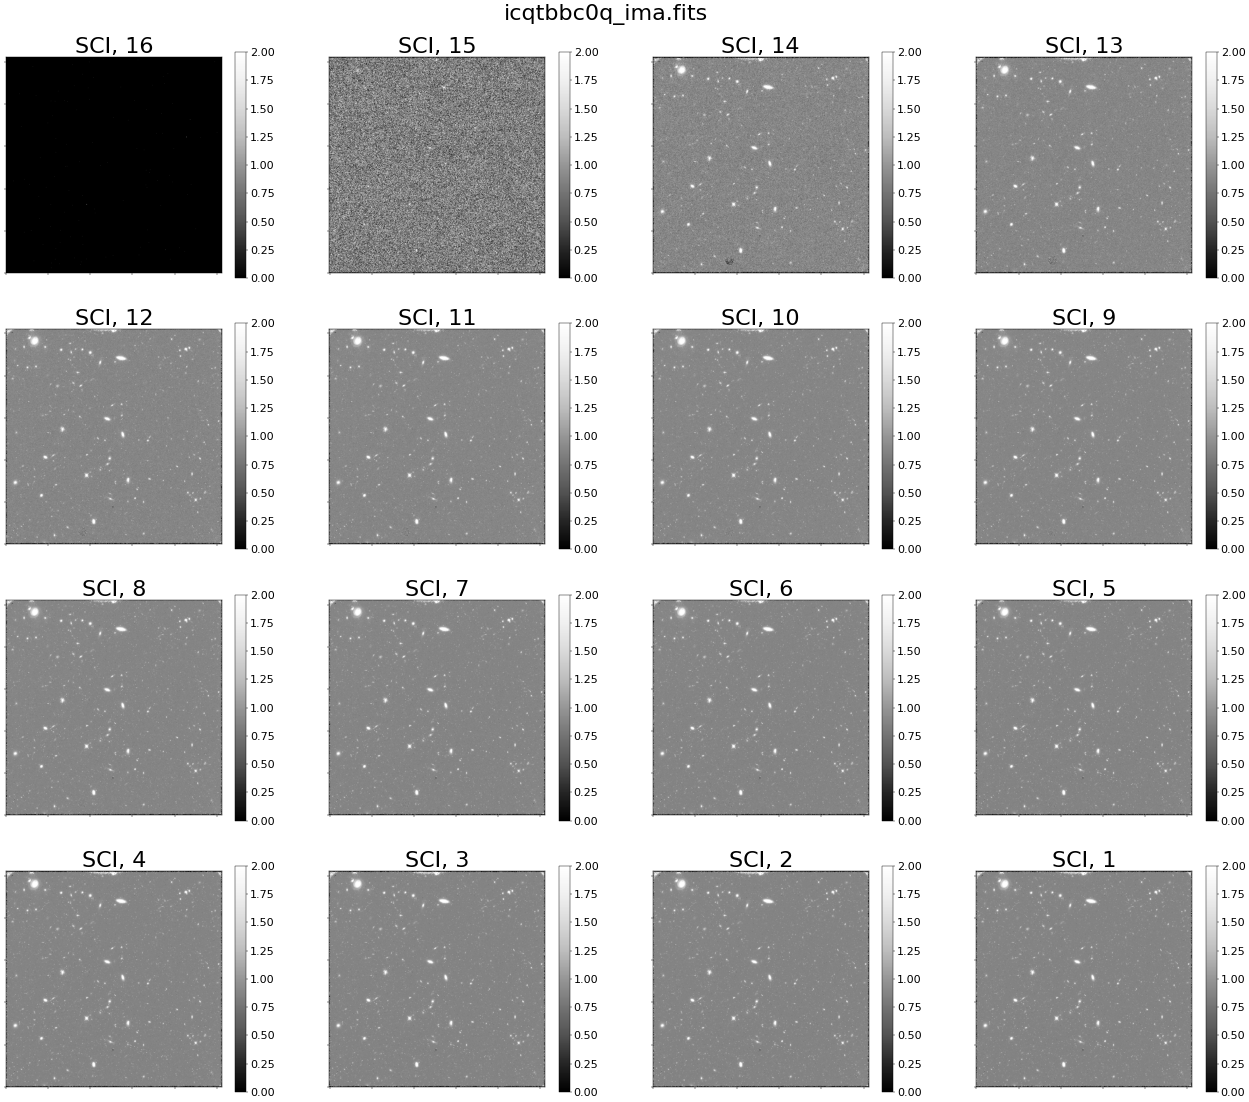

In [11]:
try:
    diff.plot_ima_subplots(ima_filename=ima_nominal, vmin=0, vmax=2)

except FileNotFoundError:
    print("No file by this name found")

To get a better sense of how the MULTIACCUM method works, we can plot the median signal accumulation in electrons up the ramp for both images. The median value works well for sparse fields where the majority of the pixels are sky.


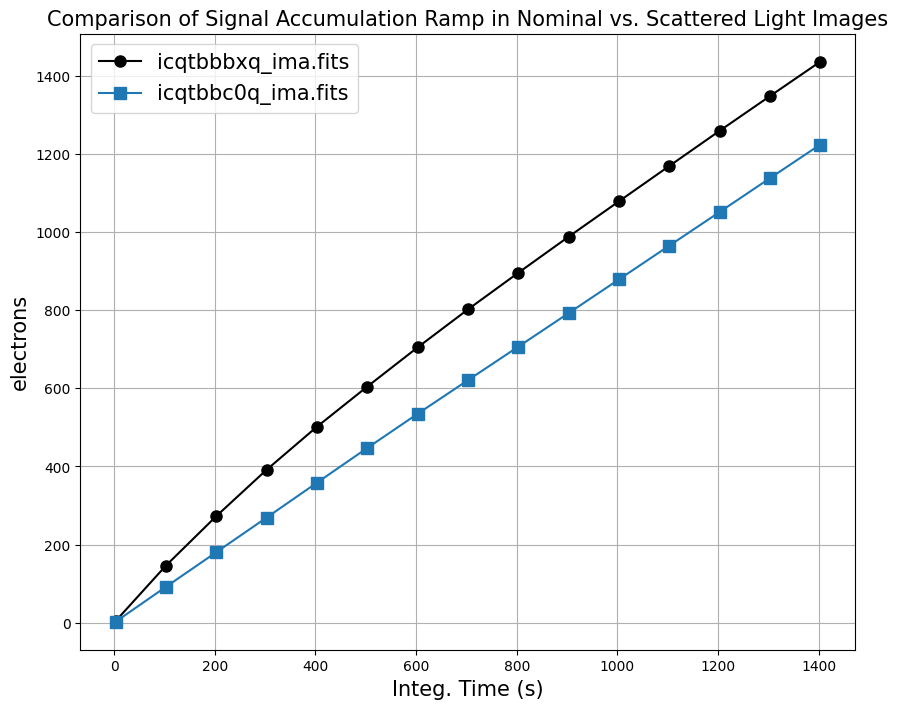

In [12]:
fig = plt.figure(figsize=(10, 8))

ima_files = [ima_scattered, ima_nominal]
# If only using one image, please remove the extraneous image from this list

marker_select = ['o', 's']
color_select = ['black', 'C0']
plt.rcParams.update({'font.size': 15})
for i, ima in enumerate(ima_files):
    path, filename = os.path.split(ima)

    cube, integ_time = diff.read_wfc3(ima)
    median_fullframe = np.nanmedian(cube, axis=(0, 1))

    plt.plot(integ_time[1:], median_fullframe[1:]*integ_time[1:],
             marker=marker_select[i], markersize=8,
             color=color_select[i], label=filename)
    plt.legend()
plt.grid()
plt.xlabel('Integ. Time (s)', fontsize=15)
plt.ylabel('electrons', fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.grid(visible=True)
_ = plt.title(
    "Comparison of Signal Accumulation Ramp in Nominal vs. Scattered Light Images", fontsize=15)

For dataset 'icqtbbc0q' (blue), we see the background signal accumulating linearly with time, whereas for dataset 'icqtbbbxq' (black), we see a non-linear background in the first portion of the exposure. 'icqtbbbxq' becomes linear in the second portion of the exposure and has the same slope as the nominal exposure. 

Next we compare sky values in different regions of the detector (left side, right side, and full frame). If you would like to specify your own regions for the left and right sides of your image, you can change the "lhs_region" and "rhs_region" parameters. Each region must be specified as a dictionary including the four "corners" (x0, x1, y0, and y1) of the region you would like to select. You may want to avoid the edges of the detector which have a large number of bad pixels and higher flat field errors. 

Here we compare the full frame ramp for each image with the ramp from the left and right sides of the detector. We compute the median signal from the left side, right side, and full frame image using the *get_median_fullframe_lhs_rhs* function from the *ima_visualization_and_differencing.py* module.

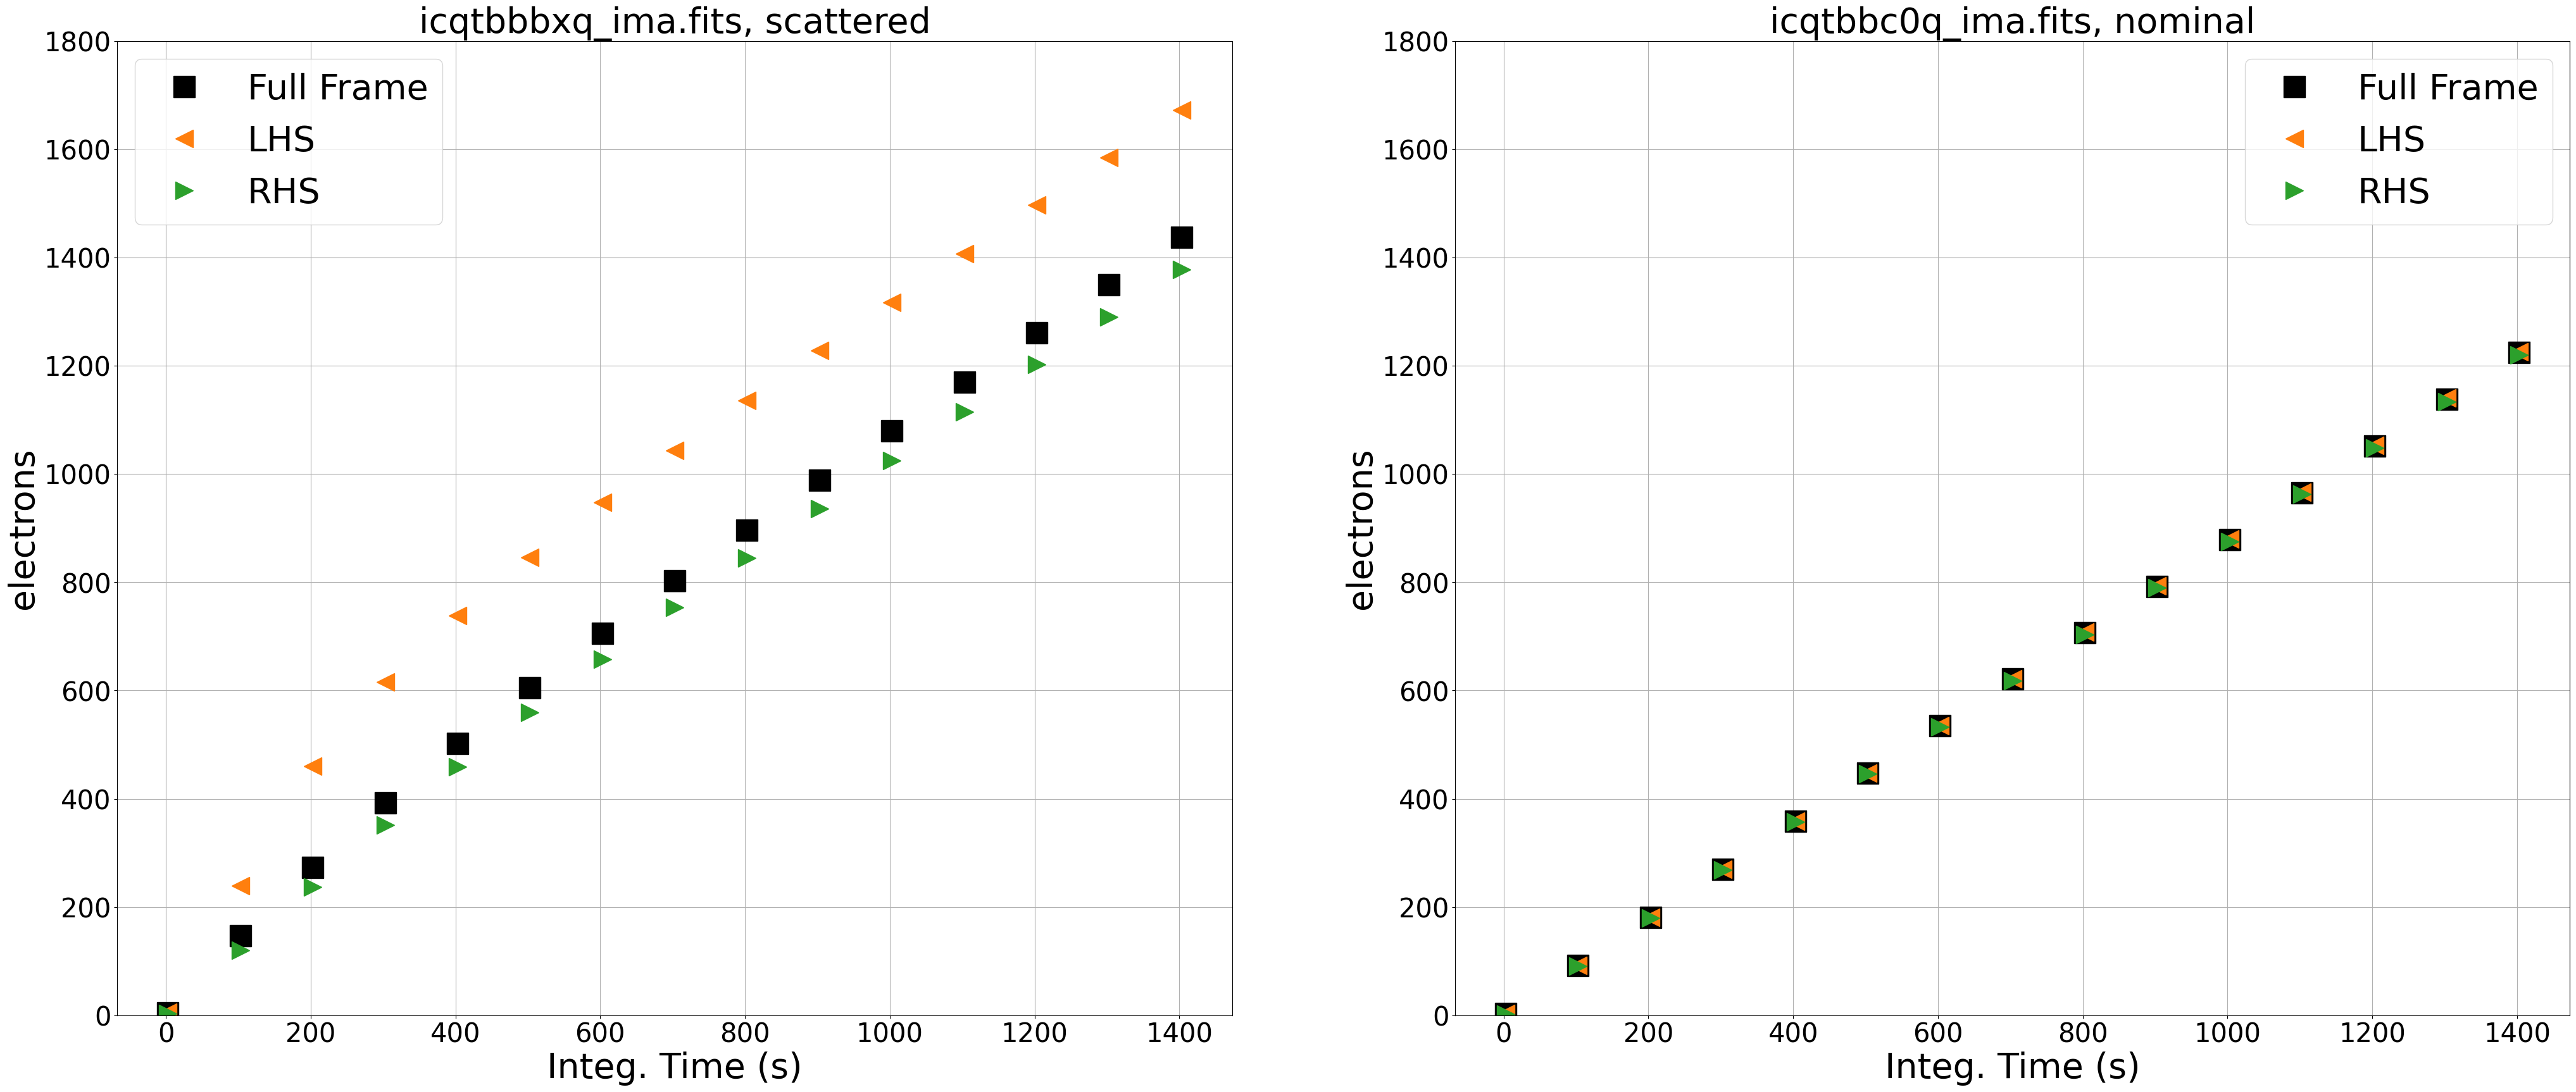

In [13]:
fig = plt.figure(figsize=(50, 20))
fig
rows = 1
columns = 2
ima_files = [ima_scattered, ima_nominal]
# If only using one image, please remove the extraneous image from this list

subplot_titles = ['scattered', 'nominal']

lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}

plt.rcParams.update({'font.size': 40})

for i, ima in enumerate(ima_files):

    path, filename = os.path.split(ima)

    cube, integ_time = diff.read_wfc3(ima)

    median_fullframe, median_lhs, median_rhs = diff.get_median_fullframe_lhs_rhs(cube,
                                                                                 lhs_region=lhs_region,
                                                                                 rhs_region=rhs_region)

    ax = fig.add_subplot(rows, columns, i+1)
    ax.plot(integ_time[1:], median_fullframe[1:]*integ_time[1:], 's',
            markersize=25, label='Full Frame',  color='black')

    ax.plot(integ_time[1:], median_lhs[1:]*integ_time[1:], '<',
            markersize=20, label='LHS', color='C1')

    ax.plot(integ_time[1:], median_rhs[1:]*integ_time[1:], '>',
            markersize=20, label='RHS', color='C2')

    ax.set_ylim(0, 1800)
    ax.grid()
    ax.set_xlabel('Integ. Time (s)')
    ax.set_ylabel('electrons')
    ax.legend(loc=0)
    _ = ax.set_title(f'{filename}, {subplot_titles[i]}', fontsize=40)
    ax.tick_params(axis="x", labelsize=30)
    ax.tick_params(axis="y", labelsize=30)


The left panel shows the observation affected by scattered light. By comparing the signal from the left side (orange triangles) and right side (green triangles) of our image, we see that the left side is brighter than the right and that the difference in total counts between the two sides is changing over the exposure. In this case, the difference between the two sides of the image is due to scattered light which varies spatially across the detector. We know the time-variable component is only due to Earth limb scattered light because this filter (F140W) is not affected by the He I 10830 Å airglow line emission (see section [7.10.2 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background)). In the following sections, we will identify the impacted reads by looking at the difference in count rates between each read.

The right panel shows the ramp plot for the nominal exposure, and we see that the signal from the left side, right side, and full frame are nearly identical. 

**Note that, in an image with an extended object, there may be a spatial dependence in the ramp plots (e.g. the right side may be higher than the left), but the slope of the ramp would be linear with time.**

## 4. Taking the Difference Between IMA Reads: The Cumulative Rate <a id="cumulative"></a>

Our first method of taking the difference between reads is as simple as subtracting each read from the one before,        e.g. $\mu$ = [SCI,15]-[SCI,14], [SCI,14]-[SCI,13],... where $\mu$ represents the median difference.  In the panels below, we now plot the the ramps in units of count rate (e-/s) in order to see how the background changes through the exposure. We use the *compute_diff_imas* function from the *ima_visualization_and_differencing.py* module, taking the cumulative difference between reads as described above, and the *plot_ramp* function from the module, which plots the median difference in count rate from the left side, right side, and full frame image.

(Note that we exclude the 0th read [SCI,16] in our difference calculations.)


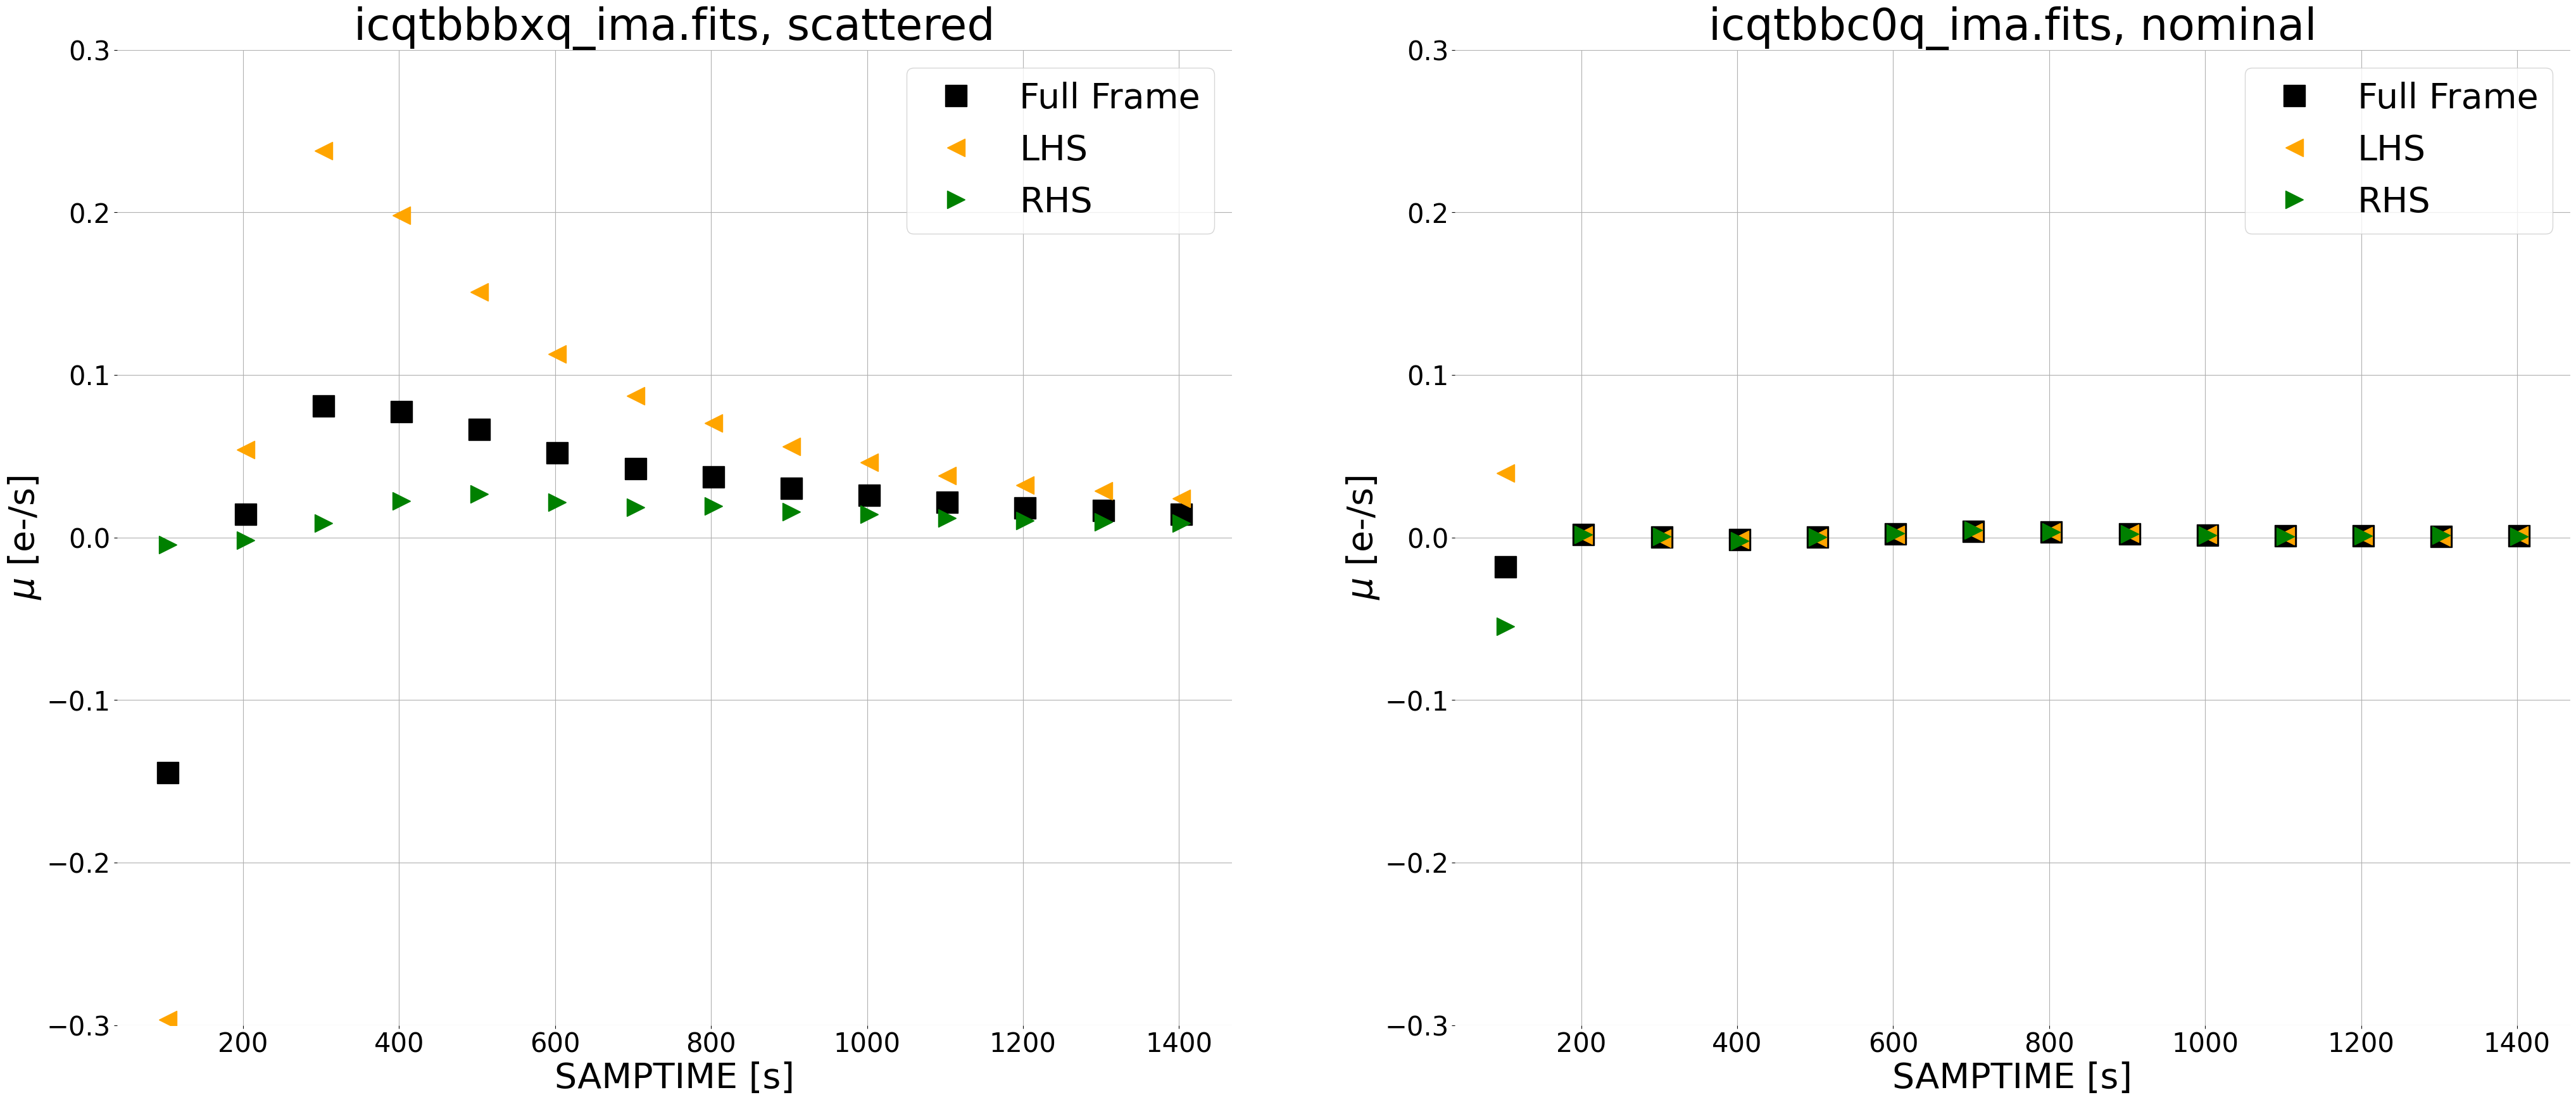

In [14]:
# If only using one image, please remove the extraneous image from this list
lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}
diff.plot_ramp_subplots(ima_files=[ima_scattered, ima_nominal],
                        difference_method='cumulative',
                        exclude_sources=False,
                        ylims=[-0.3, 0.3],
                        lhs_region=lhs_region,
                        rhs_region=rhs_region)

The left panel shows a large contribution from scattered light on the left side of the image (orange triangles) during the first portion of the exposure. This difference approaches zero toward the end of the exposure.  The right side of the image also has a slighlty elevated count rate early in the exposure, but not as extreme as the left side.

The right panel shows that the difference in count rate is effectively zero for the nominal image, as expected. 

Note that the first data point in both plots has a very large error because we are subtracting from the 1st read (~2.9 seconds), which has very little signal and large errors. 

To visualize the excess signal in two dimensions, lets make a panel plot of the differences plotted above. First, we will show the image affected by time-variable background which shows the expected spatial and time variation due to scattered light.  Note that each panel is plotted with a unique zscale to highlight large changes in the signal rate with time. We use the *panel_plot* function from the *ima_visualization_and_differencing.py* module.  

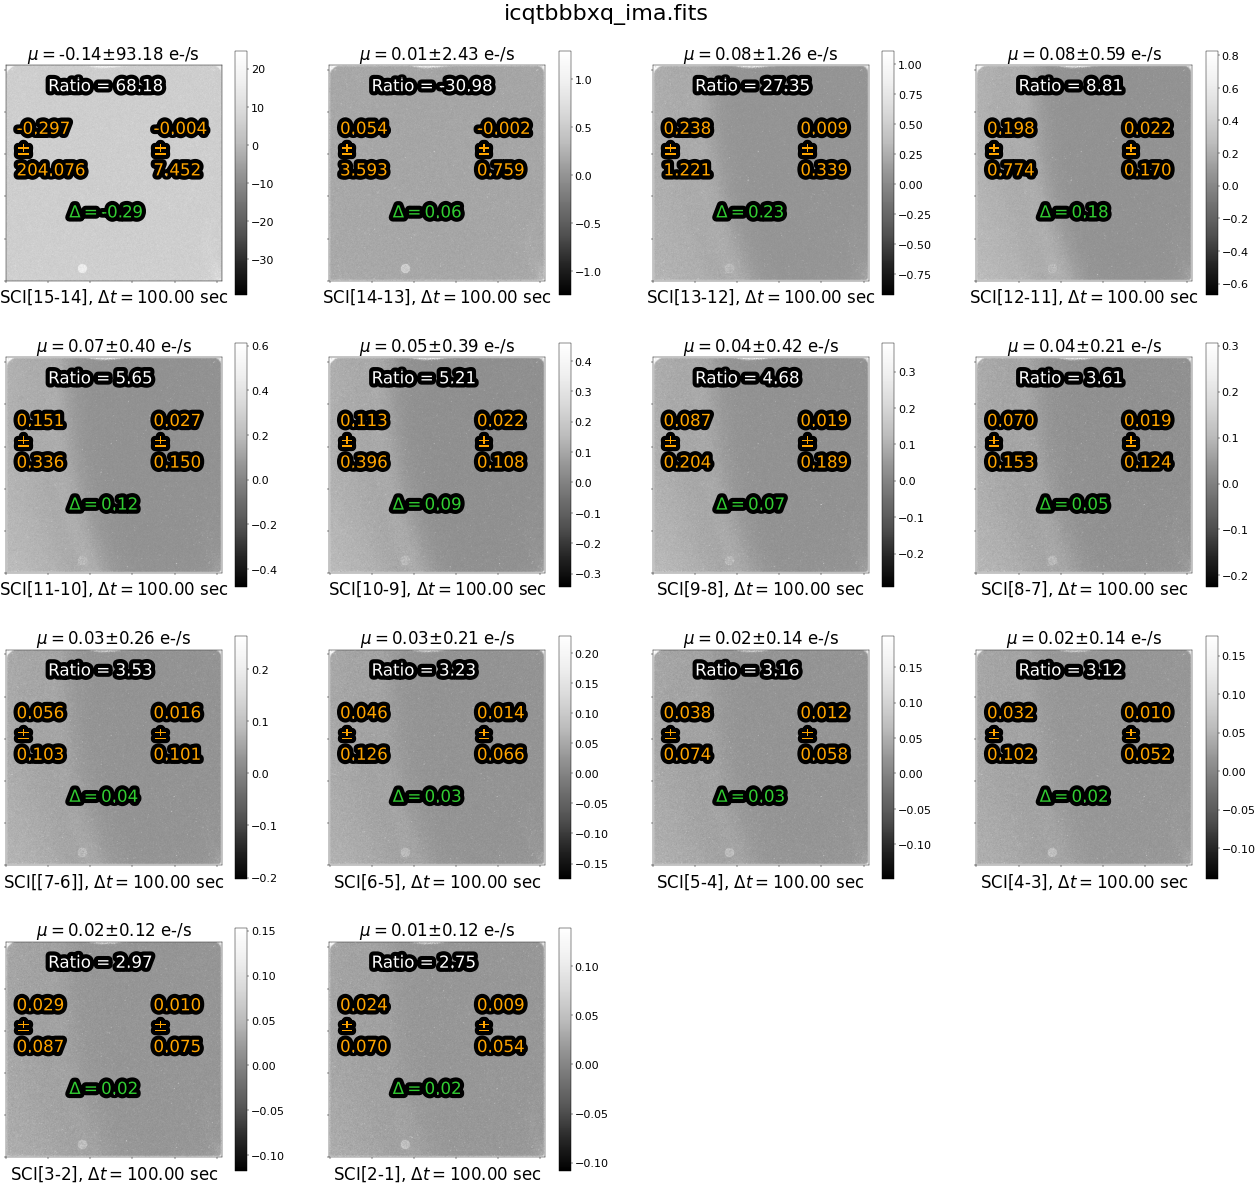

In [15]:
try:
    lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
    rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}
    diff.plot_ima_difference_subplots(ima_filename=ima_scattered,
                                      difference_method='cumulative',
                                      lhs_region=lhs_region,
                                      rhs_region=rhs_region)

except FileNotFoundError:
    print("No file by this name found")

Above each panel, we print the median difference $\mu$ in the count rate over the entire image . Below each panel, we list the IMSET difference, along with the time interval between the two IMSETs.

The statistics in orange (on the left and right side of each panel) give the median rate and standard deviation of each side of the image, respectively. The value in green 'delta' is the difference between the left and right side of the image. The value in white "Ratio" gives the ratio of the median difference in orange for the left versus the right side. 

Note that, because we took the simple difference in reads, the sources are not visible.  This leaves us with only the sky component, making it easy to identify the time-variable background and whether it is due to scattered light or Helium emission. However, since we've subtracted off the first read, we lose any information about the background level at the beginning of the exposure where the scattered light was the highest in this example. 

We see a large difference in count rate between the two sides of the image in the earlier reads. This difference decreases with time during the exposure because the scattered light is no longer present in later reads. 

Next, lets look at the difference images for the nominal exposure.

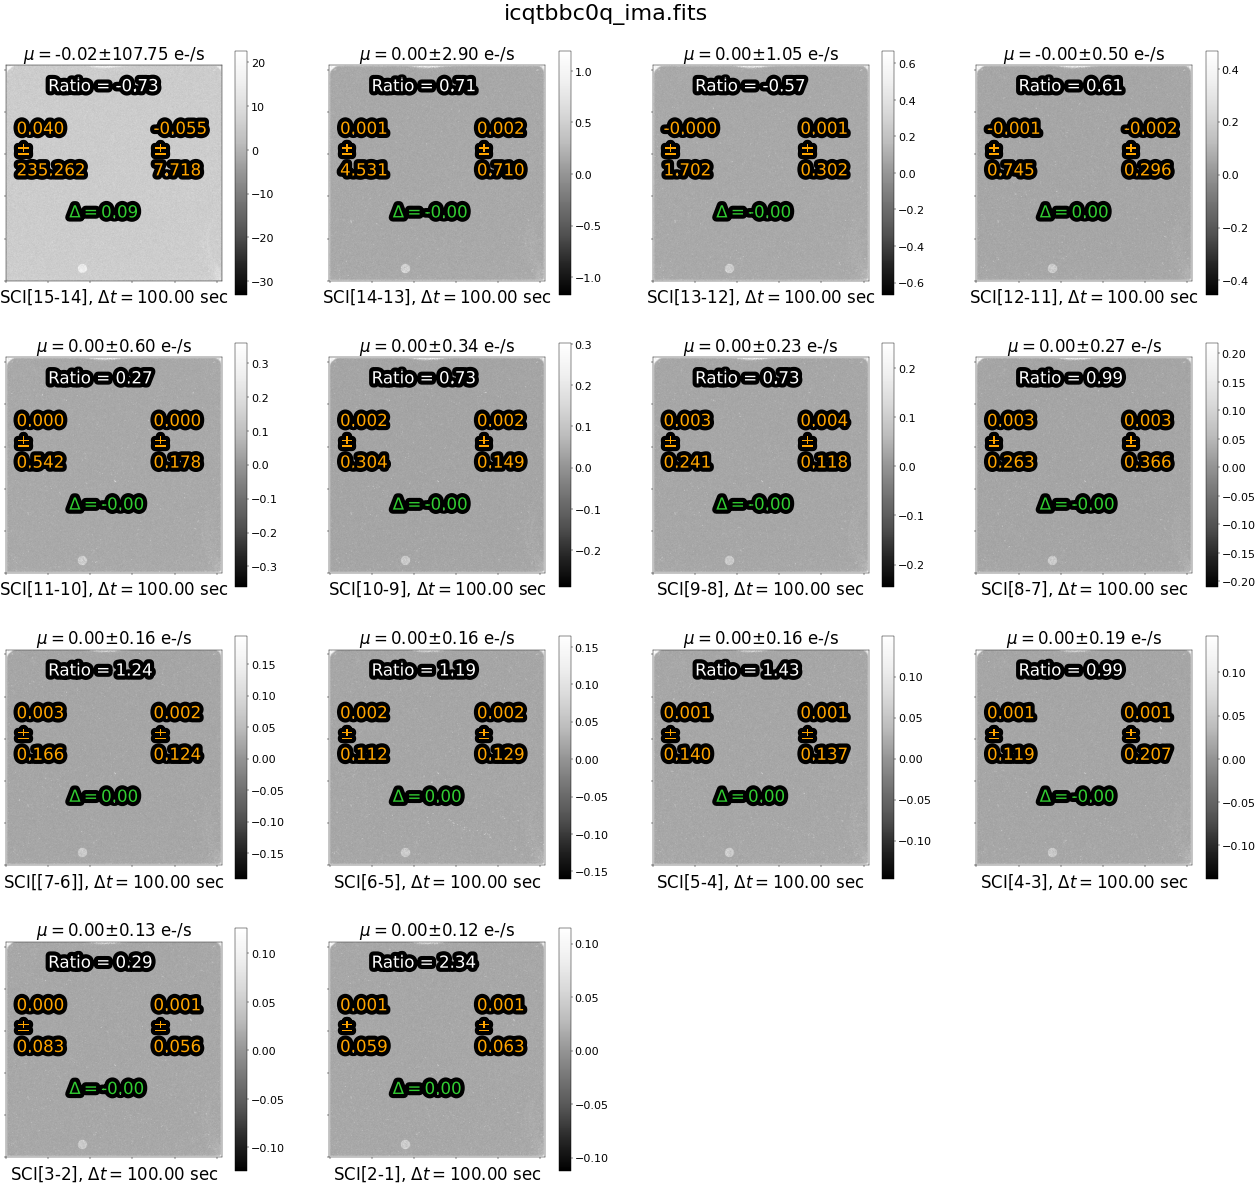

In [16]:
try:
    lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
    rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}
    diff.plot_ima_difference_subplots(ima_filename=ima_nominal,
                                      difference_method='cumulative',
                                      lhs_region=lhs_region,
                                      rhs_region=rhs_region)

except FileNotFoundError:
    print("No file by this name found")

As we expect, the differences images are blank (with the exception of a speckled pattern showing cosmic rays and differences in noise between reads). Both 'delta'($\Delta$) and $\mu$ are effectively zero in this nominal image. The ratio, in this case, is less useful becuase the signal differences between left and right are close to zero. 

## 5. A More Accurate Difference Between Reads: The Instantaneous Rate <a id="instantaneous"></a>

Here we implement a different technique to examine the count rate difference between consecutive reads. In this case, we first convert from count rate (e-/s) back to counts (e-) before taking the difference, as shown in equation 3 from [WFC3 ISR 2018-05](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-05.pdf).

![Instantaneous Difference Equation](instantaneous_diff.png)

One advantage of this method is that it does not remove information about the signal levels at the beginning of the exposure, as in the prior method. Thus the ramp plot below shows a median rate of ~1.5 e-/s for the first two differences instead of ~zero. 

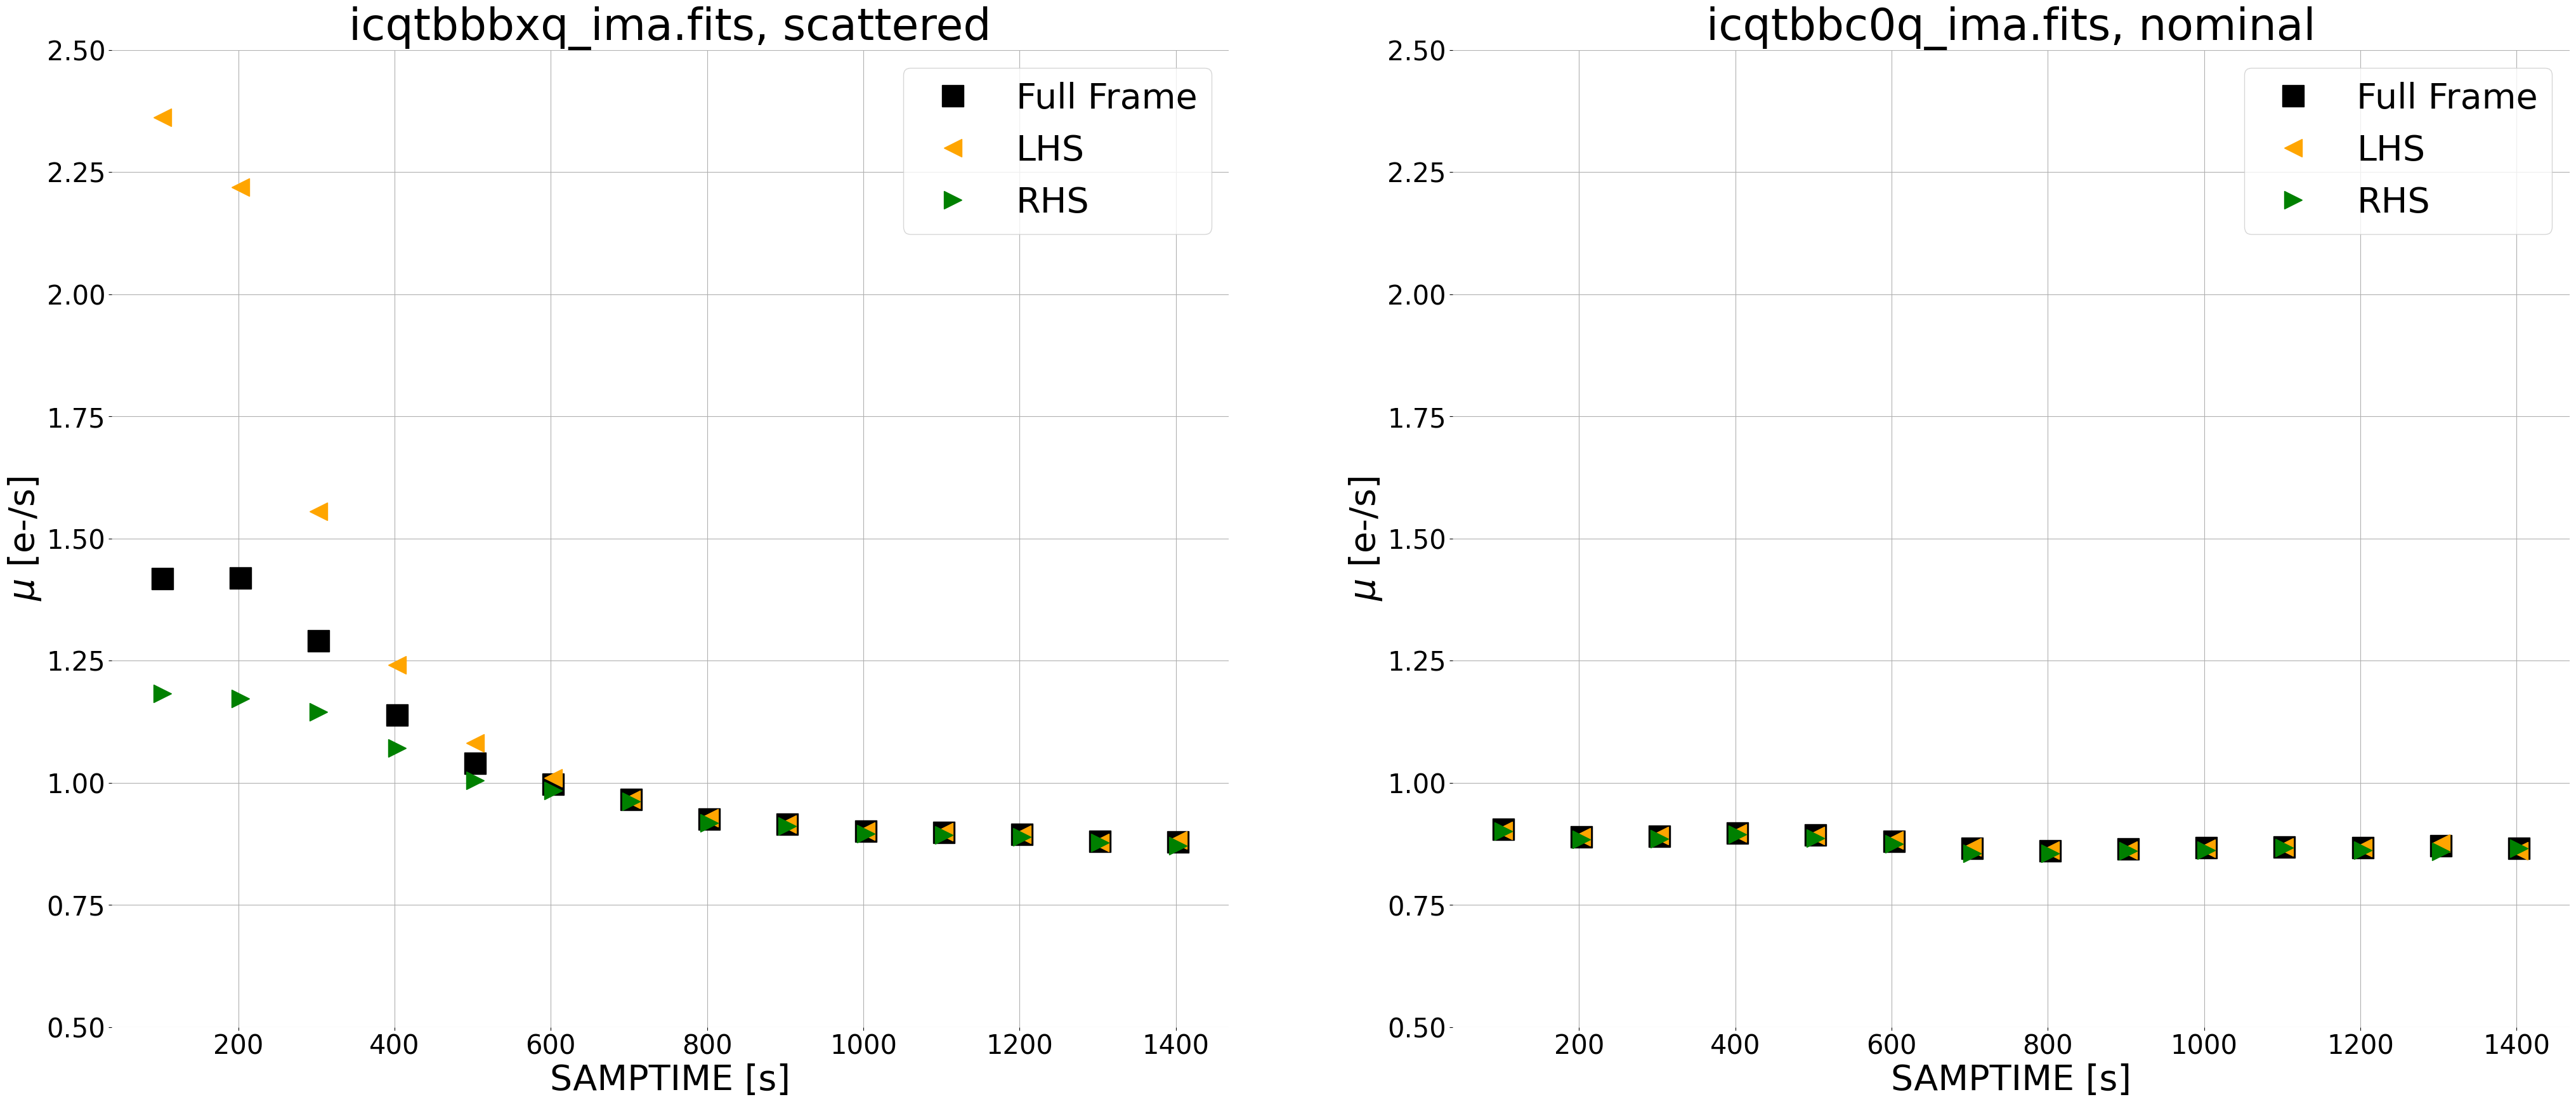

In [17]:
# If only using one image, please remove the extraneous image from this list
lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}
diff.plot_ramp_subplots(ima_files=[ima_scattered, ima_nominal],
                        difference_method='instantaneous',
                        exclude_sources=True,
                        ylims=[0.5, 2.5],
                        lhs_region=lhs_region,
                        rhs_region=rhs_region)

In our nominal exposure (right), we see a constant background due to zodiacal light at a level of ~0.9e-/s throughout. For our scattered light exposure (left), we see the same zodiacal light at a level of ~0.9e-/s in later reads, with the scattered light component affecting the first several reads where the median count rate for the left side (orange triangles) is larger than the right side (green triangles). 

In the panel plot (below), we see that sources (small galaxies) are visible in the difference images using this new method, whereas in the cumulative difference method they are not. Note that this may complicate the analysis of the spatial background (e.g. left versus right) for images with extended targets, such as large galaxies. In this case, users may wish to adjust the regions of the detector used for the ramp plots. We therefore recommend inspecting both the panel plots as well as the ramp fits for diagnosing any issues with the data. 

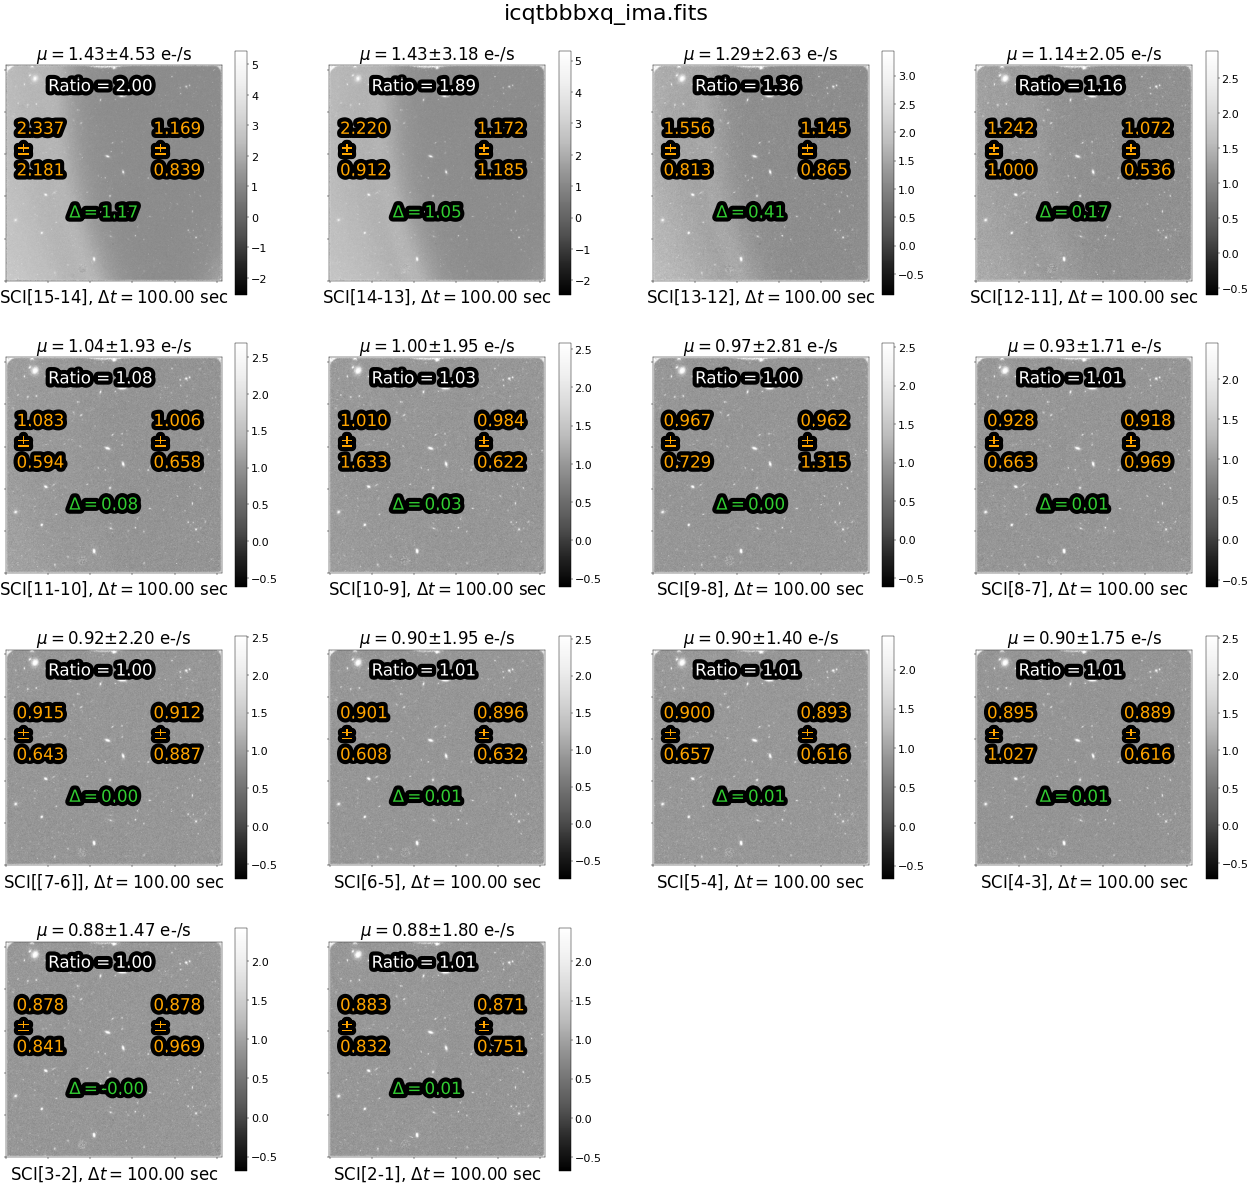

In [18]:
try:
    lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
    rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}
    diff.plot_ima_difference_subplots(ima_filename=ima_scattered,
                                      difference_method='instantaneous',
                                      lhs_region=lhs_region,
                                      rhs_region=rhs_region)

except FileNotFoundError:
    print("No file by this name found")

In this figure, we see that the ratio of instantaneous rate for the left versus right side of the image is ~1.0 for all but the first few reads. 

In a subsequent notebook, Correcting for Scattered Light in IR Exposures by Reprocessing with Calwf3 (O'Connor, in prep.), we show how to exclude these specific reads from the exposure and reprocess the image with `calwf3`. For this dataset, we exlude the first 6 reads, where the ratio is greater than 1.1 e-/s. While this reduces the total exposure from 1403 to 903 seconds, it removes the spatial component from the sky background and allows for a more accurate 'up-the-ramp' fit with `calwf3`.

In a separate notebook, Correcting for Scattered Light in IR Exposures by Manually Removing Bad Data(O'Connor, in prep.), we correct the final image product by manually removing bad reads from the IMA file, again exluding reads where the ratio is greater than 1.1 e-/s. 

For comparison, we show the difference images for the nominal exposure (below) which do not show any scattered light artifacts.

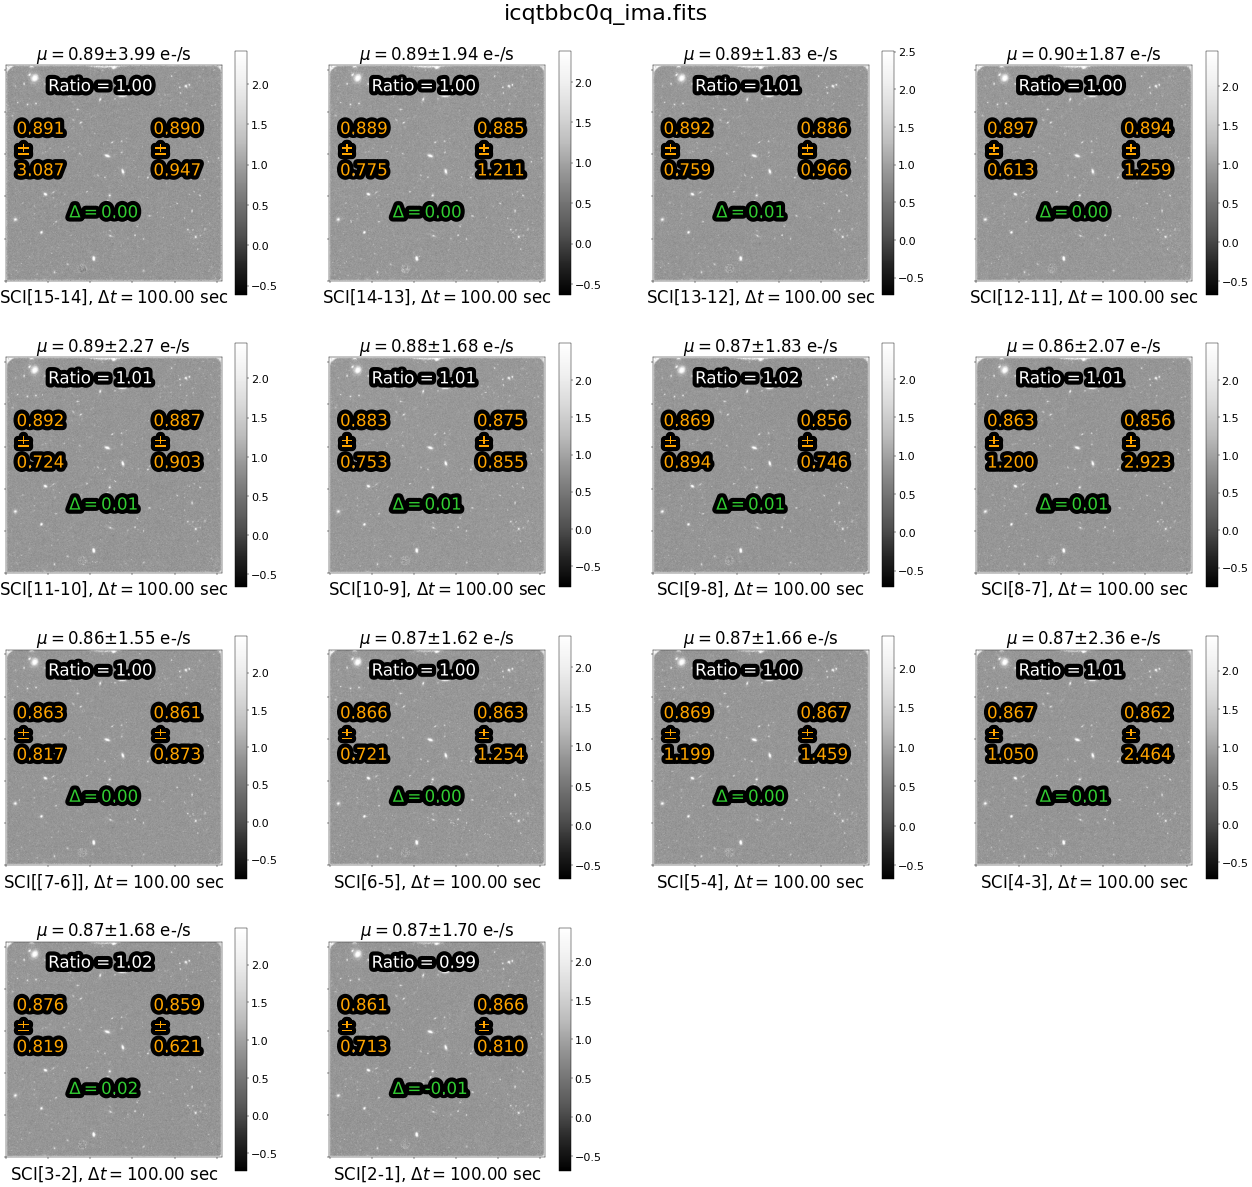

In [19]:
try:
    diff.plot_ima_difference_subplots(ima_filename=ima_nominal,
                                      difference_method='instantaneous',
                                      lhs_region=lhs_region,
                                      rhs_region=rhs_region)

except FileNotFoundError:
    print("No file by this name found")

## 6.  Conclusions <a id="conclusions"></a>


**Congratulations, you have completed the notebook.**

You should now be familiar with: 
- How to find and select individual reads in an IMA file
- How to display individual reads
- How to plot the signal accumulation ramp of a WFC3/IR IMA file
- How to plot the difference in signal between reads using two different methods


This notebook can be used to help identify issues with WFC3/IR images, for example time variable backgrounds. To correct for scattered light background in IR exposures, please see the subsequent notebooks Correcting for Scattered Light in WFC3/IR Exposures: Using `calwf3` to Exclude Bad Reads (O'Connor, in prep.) and Correcting for Scattered Light in IR Exposures: Manually Excluding Bad Reads (O'Connor, in prep.), which makes use of the same dataset highlighted in this tutorial. 

For a tutorial on how to correct time-variable background due to the He I 10830 Å airglow line background, which has no spatial signature, please see the notebook [Correcting for Helium Line Emission Background in IR Exposures using the “Flatten-Ramp” Technique](https://github.com/spacetelescope/WFC3Library/tree/master/notebooks/tvb_flattenramp). 

## Additional Resources <a id="add"></a>

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)


## About this Notebook <a id="about"></a>

**Authors:** 
- Anne O'Connor, WFC3 Instrument
- Harish Khandrika, WFC3 Instrument
- Jennifer Mack, WFC3 Instrument
- Annalisa Calamida, WFC3 Instrument

**Updated On:** 2023-05-05

## Citations <a id="cite"></a>

If you use `numpy` or `astropy` for published research, please cite the
authors. Follow these links for more information about citing `numpy` and
`astropy`:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `wfc3tools`](https://wfc3tools.readthedocs.io/en/latest/)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)


If you use this notebook, or information from the WFC3 Data Handbook, Instrument Handbook,
or WFC3 ISRs for published research, please cite them:
* Citing this notebook:
    Please cite the primary author and year, and hyperlink the notebook or WFC3 Library
    
* [Citing the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb#:~:text=Citation,%2C%20(Baltimore%3A%20STScI).)

* [Citing the WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb#:~:text=Citation,14.0%E2%80%9D%20(Baltimore%3A%20STScI))

* [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)

* [Instrument Science Report WFC3 2018-05](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-05.pdf)



<hr>


[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 